# 제주 관광객 소비패턴 변화 분석(BC카드)
## 1. Definition
### Overview
2014년~2016년 제주도 내 내국인 관광객의 카드 소비 패턴 분석을 통해서 어떠한 상권에서 어떠한 소비를 많이 하는지에 대해 분석하고, 이를 통해 데이터가 주어지면 어떠한 상권에서 어떠한 업종이 유망할 지에 대한 모델을 만들고자 한다.
### Metric
## 2. Data Exploration
### import library

In [12]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from glob import glob
import os, random, time, gc, warnings

from tqdm import tqdm_notebook

import lightgbm as lgbm
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import mean_squared_error

# from catboost import CatBoostRegressor
from sklearn.feature_selection import RFECV


from sklearn.cluster import KMeans

from datetime import datetime

from math import sqrt

import folium
from folium import Marker, Icon, CircleMarker
from folium.plugins import MarkerCluster

from pdpbox import pdp, info_plots

warnings.filterwarnings('ignore')

pd.set_option('max_columns', 500)
pd.set_option('max_rows', 500)

%matplotlib inline

In [13]:
os.listdir('./input/')

['domestic_consumption_data.csv',
 'market_consumption_data.csv',
 'reference_data',
 'supplementary_data']

### Load Dataset

In [111]:
data = pd.read_csv('./input/domestic_consumption_data.csv',parse_dates=['기준년월','데이터기준일자'],encoding='ANSI')
data.head()

,기준년월,관광객 유형,제주 대분류,제주 중분류,업종명,성별,연령대별,카드이용금액,카드이용건수,건당이용금액,데이터기준일자
0,2014-09-01,내국인 관광객,서귀포시,대륜동,농축수산품,여,50대,14434000,67,215433,2017-02-16
1,2014-09-01,내국인 관광객,서귀포시,대륜동,농축수산품,남,50대,15119000,72,209986,2017-02-16
2,2014-09-01,내국인 관광객,서귀포시,대륜동,농축수산품,여,40대,7609500,41,185598,2017-02-16
3,2014-09-01,내국인 관광객,서귀포시,남원읍,농축수산품,남,50대,7092500,40,177313,2017-02-16
4,2014-09-01,내국인 관광객,서귀포시,대륜동,농축수산품,남,40대,9098500,59,154212,2017-02-16


In [112]:
data.columns

Index(['기준년월', '관광객 유형', '제주 대분류', '제주 중분류', '업종명', '성별', '연령대별', ' 카드이용금액 ',
       ' 카드이용건수 ', '건당이용금액', '데이터기준일자'],
      dtype='object')

### Columns
- 기준년월 : 해당 데이터가 발생한 날짜
- 관광객 유형 : 모두 내국인 관광객으로 동일
- 제주 대분류 : 제주시, 서귀포시
- 제주 중분류 : 읍면동
- 업종명 : 업종의 종류를 나타낸다.
- 성별 : 남/여
- 연령대별 : 연령대
- 카드이용금액
- 카드이용건수
- 건당이용금액 : 카드이용금액 / 카드이용건수
- 데이터기준일자 : database가 만들어진 날짜

'데이터 기준일자'은 2017-02-16으로 모두 동일하고,  '관광객 유형'은 모두 내국인 관광객으로 동일하므로 삭제한다. 또한 column명 중 불필요한 공백은 제거한다.

In [113]:
# columns명 중 앞뒤 공백이 있는 string은 제거해준다.
data.drop(['관광객 유형','데이터기준일자'],axis=1,inplace=True)
data.rename(columns={' 카드이용금액 ':'카드이용금액',' 카드이용건수 ': '카드이용건수'},inplace=True)
data.columns

Index(['기준년월', '제주 대분류', '제주 중분류', '업종명', '성별', '연령대별', '카드이용금액', '카드이용건수',
       '건당이용금액'],
      dtype='object')

중복되는 데이터는 없다.

In [91]:
display(data.shape)
display(data.duplicated().sum())

(13146, 9)

0

### Missing Value
결측치는 없다.

In [351]:
# 한글 글꼴 설정
import matplotlib.font_manager as fm

fm.get_fontconfig_fonts()
plt.rc('font', family='Malgun Gothic')

In [140]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13146 entries, 0 to 13145
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   기준년월    13146 non-null  datetime64[ns]
 1   제주 대분류  13146 non-null  object        
 2   제주 중분류  13146 non-null  object        
 3   업종명     13146 non-null  object        
 4   성별      13146 non-null  object        
 5   연령대별    13146 non-null  object        
 6   카드이용금액  13146 non-null  int64         
 7   카드이용건수  13146 non-null  int64         
 8   건당이용금액  13146 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(5)
memory usage: 924.5+ KB


### 기준년월
모든 데이터들은 매월 1일자로 데이터가 기록되어있다.

In [139]:
display(print(data['기준년월'].agg(['min','max']),'\n'))
display(print(data['기준년월'].unique()))

min   2014-09-01
max   2016-08-01
Name: 기준년월, dtype: datetime64[ns] 



None

['2014-09-01T00:00:00.000000000' '2014-10-01T00:00:00.000000000'
 '2014-11-01T00:00:00.000000000' '2014-12-01T00:00:00.000000000'
 '2015-01-01T00:00:00.000000000' '2015-02-01T00:00:00.000000000'
 '2015-03-01T00:00:00.000000000' '2015-04-01T00:00:00.000000000'
 '2015-05-01T00:00:00.000000000' '2015-06-01T00:00:00.000000000'
 '2015-07-01T00:00:00.000000000' '2015-08-01T00:00:00.000000000'
 '2015-09-01T00:00:00.000000000' '2015-10-01T00:00:00.000000000'
 '2015-11-01T00:00:00.000000000' '2015-12-01T00:00:00.000000000'
 '2016-01-01T00:00:00.000000000' '2016-02-01T00:00:00.000000000'
 '2016-03-01T00:00:00.000000000' '2016-04-01T00:00:00.000000000'
 '2016-05-01T00:00:00.000000000' '2016-06-01T00:00:00.000000000'
 '2016-07-01T00:00:00.000000000' '2016-08-01T00:00:00.000000000']


None

### 제주 대분류, 제주 중분류

In [93]:
data.columns

Index(['기준년월', '제주 대분류', '제주 중분류', '업종명', '성별', '연령대별', ' 카드이용금액 ', ' 카드이용건수 ',
       '건당이용금액'],
      dtype='object')

In [94]:
city_in_jejudo = data['제주 대분류'].unique()
town_in_jejudo = data['제주 중분류'].unique()
display(print('도시의 갯수 : {}'.format(len(city_in_jejudo))))
display(print(city_in_jejudo))
display(print('동네의 갯수 : {}'.format(len(town_in_jejudo))))
display(print(town_in_jejudo))

도시의 갯수 : 2


None

['서귀포시' '제주시']


None

동네의 갯수 : 10


None

['대륜동' '남원읍' '연동' '예래동' '이도2동' '삼도2동' '용담2동' '노형동' '애월읍' '성산읍']


None

In [116]:
os.listdir('.')

['.git',
 '.idea',
 '.ipynb_checkpoints',
 'consumption pattern analysis of jeju tourist.ipynb',
 'get_position.py',
 'input',
 'jeju_town_pos',
 'NanumFontSetup_TTF_BARUNGOTHIC']

In [120]:
town_pos = pd.read_csv('./jeju_town_pos')
display(town_pos.shape)
display(town_pos)

(10, 3)

,address,latitude,longitude
0,대륜동,33.248109,126.511403
1,남원읍,33.279925,126.720650
2,연동,34.794701,126.391650
3,예래동,33.254292,126.397863
4,이도2동,33.497068,126.535275
5,삼도2동,33.511717,126.522188
6,용담2동,33.511492,126.511663
7,노형동,33.483085,126.477175
8,애월읍,33.462010,126.329488
9,성산읍,33.442135,126.911013


In [130]:
import math
# create map, 소비 데이터의 가맹점이 존재하는 지역을 지도에 표시하였다.
jeju_map_solo = folium.Map(location=[33.3617,126.5292],tiles='cartodbpositron',zoom_start=10)

# Add points to the map
mc = MarkerCluster()
for idx, row in town_pos.iterrows():
    if not math.isnan(row['longitude']) and not math.isnan(row['latitude']):
        mc.add_child(Marker([row['latitude'],row['longitude']],popup=row['address']))
jeju_map_solo.add_child(mc)

jeju_map_solo

### 업종명
중간에 불필요한 공백이 있는 data는 공백을 없애주도록 한다.

In [95]:
upjong = data['업종명'].unique()
print(f'업종의 갯수 : {len(upjong)}\n',upjong)

업종의 갯수 : 14
 ['농축수산품' '스포츠레져용품' '골프 용품' '악세 사리' '의원' '안경' '정장(여성)' '기념품 점' '기타음료식품'
 '슈퍼 마켓' '신   발' '약국' '스넥' '귀 금 속']


In [102]:
# 불필요한 공백 제거
data['업종명'] = [uj.replace(" ","") for uj in data['업종명']]
data['업종명'].unique()

array(['농축수산품', '스포츠레져용품', '골프용품', '악세사리', '의원', '안경', '정장(여성)', '기념품점',
       '기타음료식품', '슈퍼마켓', '신발', '약국', '스넥', '귀금속'], dtype=object)

### 성별

In [97]:
sex = data['성별'].unique()
print(sex)

['여' '남']


,업종명,성별,카드이용금액
0,골프 용품,남,33892800
1,골프 용품,여,3321000
2,귀 금 속,여,2180100
3,기념품 점,남,3997426584
4,기념품 점,여,3867428411
5,기타음료식품,남,694770536
6,기타음료식품,여,643329960
7,농축수산품,남,7064962946
8,농축수산품,여,6027597440
9,슈퍼 마켓,남,6768028620


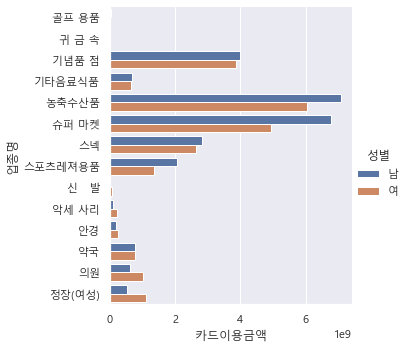

In [356]:
# 성별에 따른 각각의 업종 매출액
card_usage_amount_by_sex = data.groupby(['업종명','성별'])['카드이용금액'].sum()
display(card_usage_amount_by_sex.to_frame(name="카드이용금액").reset_index())
# sns.set(rc={'figure.figsize':(80,10)})

g = sns.catplot(x='카드이용금액',y='업종명', hue='성별',
               data=card_usage_amount_by_sex.to_frame(name="카드이용금액").reset_index(),
               orient='h', kind='bar')

### 연령대별

In [98]:
age_grp = data['연령대별'].unique()
print(age_grp)

['50대' '40대' '30대' '20대']


### 카드이용금액

In [304]:
data.columns

Index(['기준년월', '제주 대분류', '제주 중분류', '업종명', '성별', '연령대별', '카드이용금액', '카드이용건수',
       '건당이용금액'],
      dtype='object')

In [114]:
card_usage_amount = data['카드이용금액']
card_usage_amount.agg(['min','max'])

min       36100
max    64277700
Name: 카드이용금액, dtype: int64

Text(0.5, 0.98, 'Card usage amount by industry')

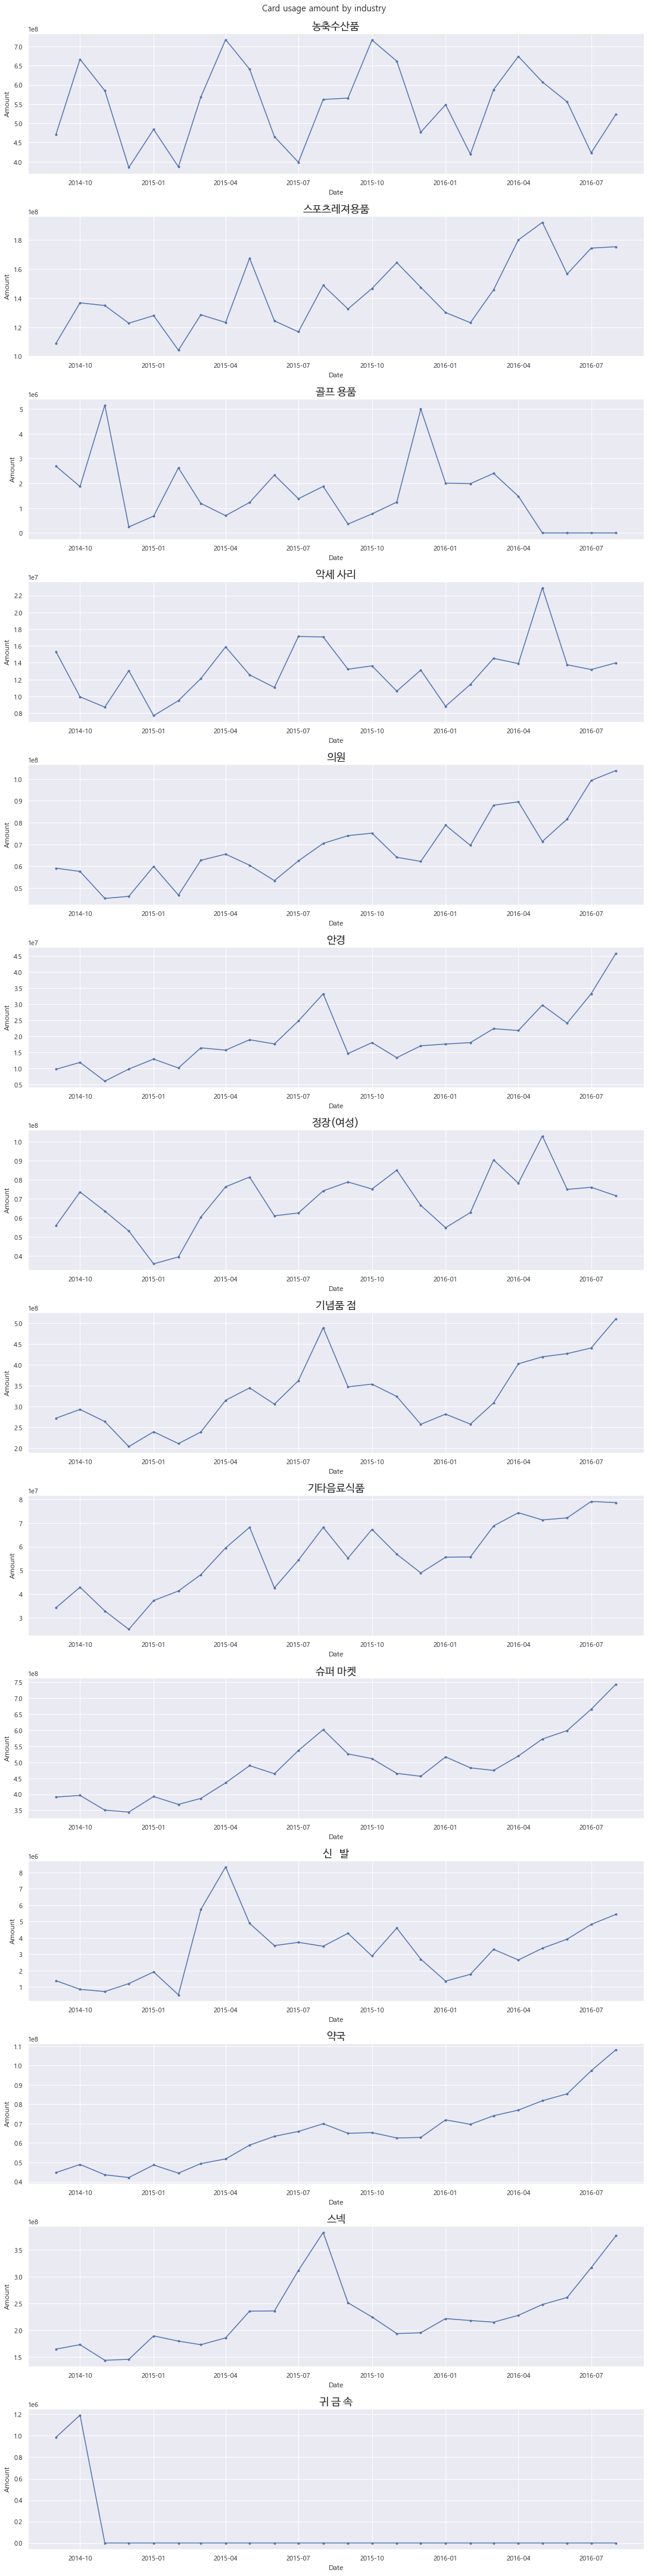

In [404]:
# 시간에 따른 업종별 카드이용금액
card_usage_amount_by_industry = data.groupby(['업종명','기준년월'])['카드이용금액'].sum()
dates = data['기준년월'].unique()
fig, axes = plt.subplots(nrows=len(upjong),figsize=(15,60),constrained_layout=True)

# 업종중 특정날짜의 데이터가 없는 경우가 있다. 따라서 특정날짜의 data를 0으로 하여 추가한다.
for idx, industry in enumerate(upjong):
    result = card_usage_amount_by_industry.loc[(industry,dates)]
    date_by_industry = result.index.get_level_values('기준년월')
    for date in dates:
        if date not in date_by_industry:
            result[(industry,date)]=0          
           
    axes[idx].plot(dates,result,color='b',marker='.')
    axes[idx].set_xlabel('Date')
    axes[idx].set_ylabel('Amount')
    axes[idx].set_title(industry,fontproperties=fontprop)

plt.suptitle('Card usage amount by industry')

Text(0.5, 0.98, 'Card usage amount by industry')

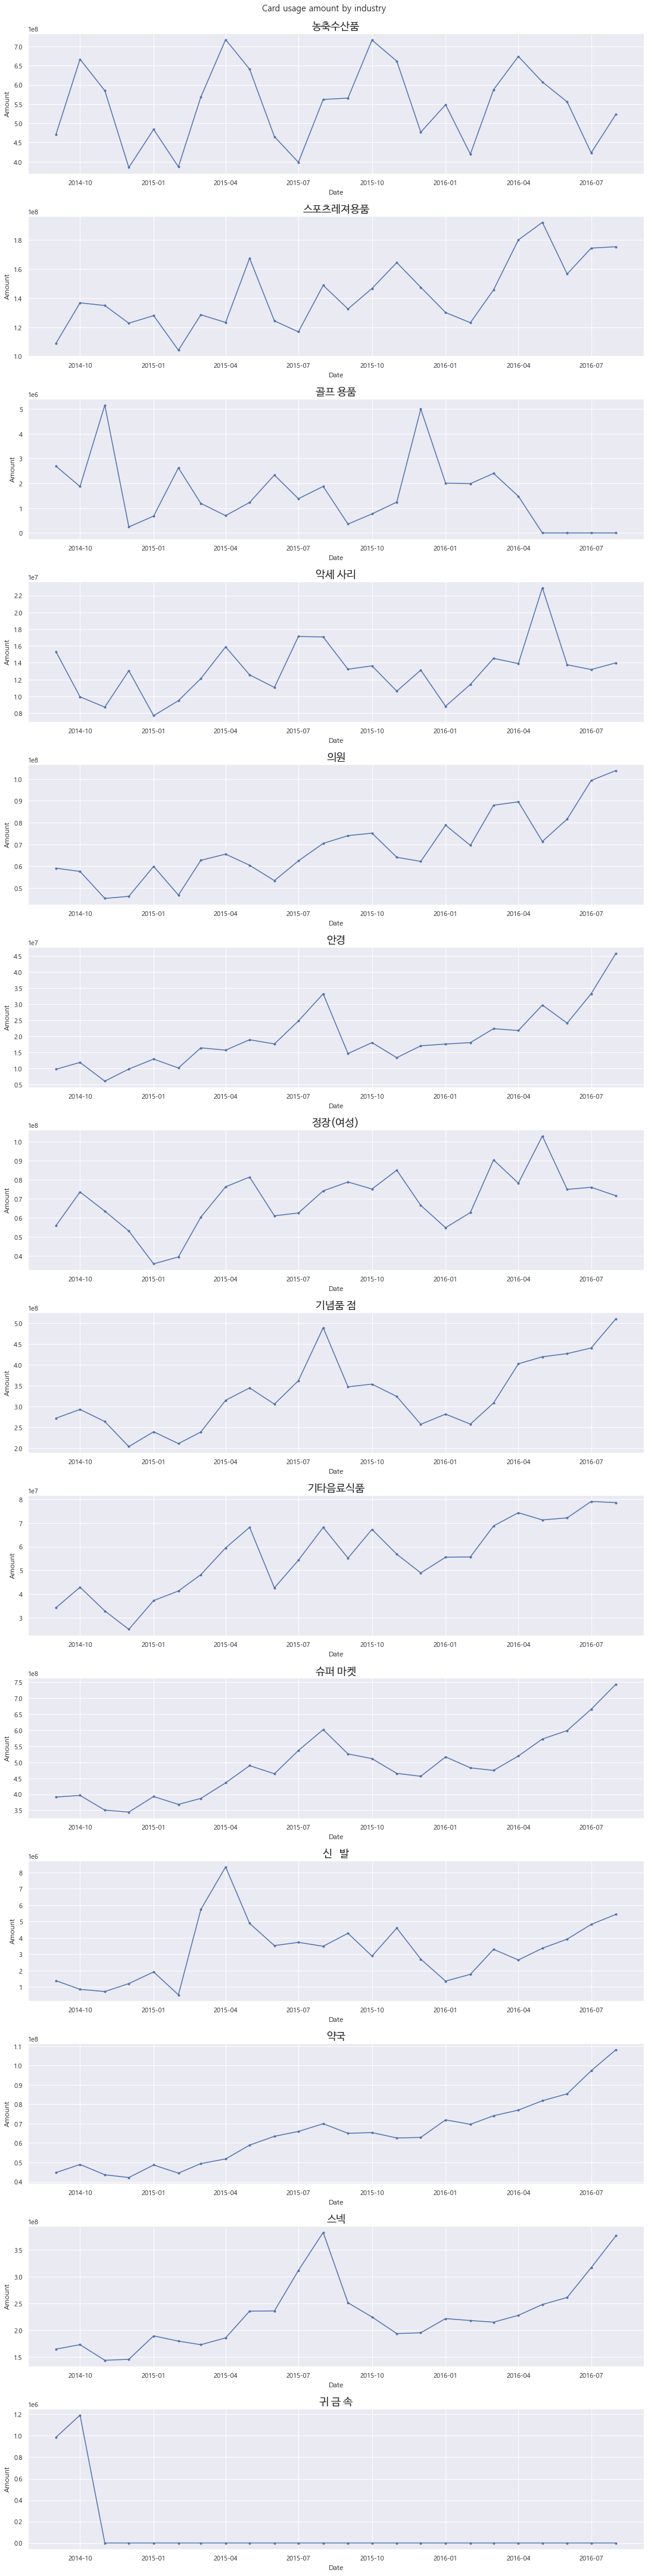

In [436]:
# 시간에 따른 업종별 카드이용금액
card_usage_amount_by_industry = data.groupby(['업종명','기준년월'])['카드이용금액'].sum()
dates = data['기준년월'].unique()
fig, axes = plt.subplots(nrows=len(upjong),figsize=(15,60),constrained_layout=True)

# 업종중 특정날짜의 데이터가 없는 경우가 있다. 따라서 특정날짜의 data를 0으로 하여 추가한다.
for idx, industry in enumerate(upjong):
    result = card_usage_amount_by_industry.loc[(industry,dates)]
    date_by_industry = result.index.get_level_values('기준년월')
    for date in dates:
        if date not in date_by_industry:
            result[(industry,date)]=0          
           
    axes[idx].plot(dates,result,color='b',marker='.')
    axes[idx].set_xlabel('Date')
    axes[idx].set_ylabel('Amount')
    axes[idx].set_title(industry,fontproperties=fontprop)

plt.suptitle('Card usage amount by industry')

In [ ]:
# 시간에 따른 업종별 카드이용건수
number_of_card_usage_by_industry = data.groupby(['업종명','기준년월'])['카드이용건수'].sum()
dates = data['기준년월'].unique()
fig, axes = plt.subplots(nrows=len(upjong),figsize=(15,60),constrained_layout=True)

# 업종중 특정날짜의 데이터가 없는 경우가 있다. 따라서 특정날짜의 data를 0으로 하여 추가한다.
for idx, industry in enumerate(upjong):
    result = number_of_card_usage_by_industry.loc[(industry,dates)]
    date_by_industry = result.index.get_level_values('기준년월')
    for date in dates:
        if date not in date_by_industry:
            result[(industry,date)]=0          
           
    axes[idx].plot(dates,result,color='b',marker='.')
    axes[idx].set_xlabel('Date')
    axes[idx].set_ylabel('Amount')
    axes[idx].set_title(industry,fontproperties=fontprop)

plt.suptitle('Number of card usage by industry')

Text(0.5, 0.98, 'Number of card usage by industry')

Text(0.5, 0.98, 'Card usage amount by town')

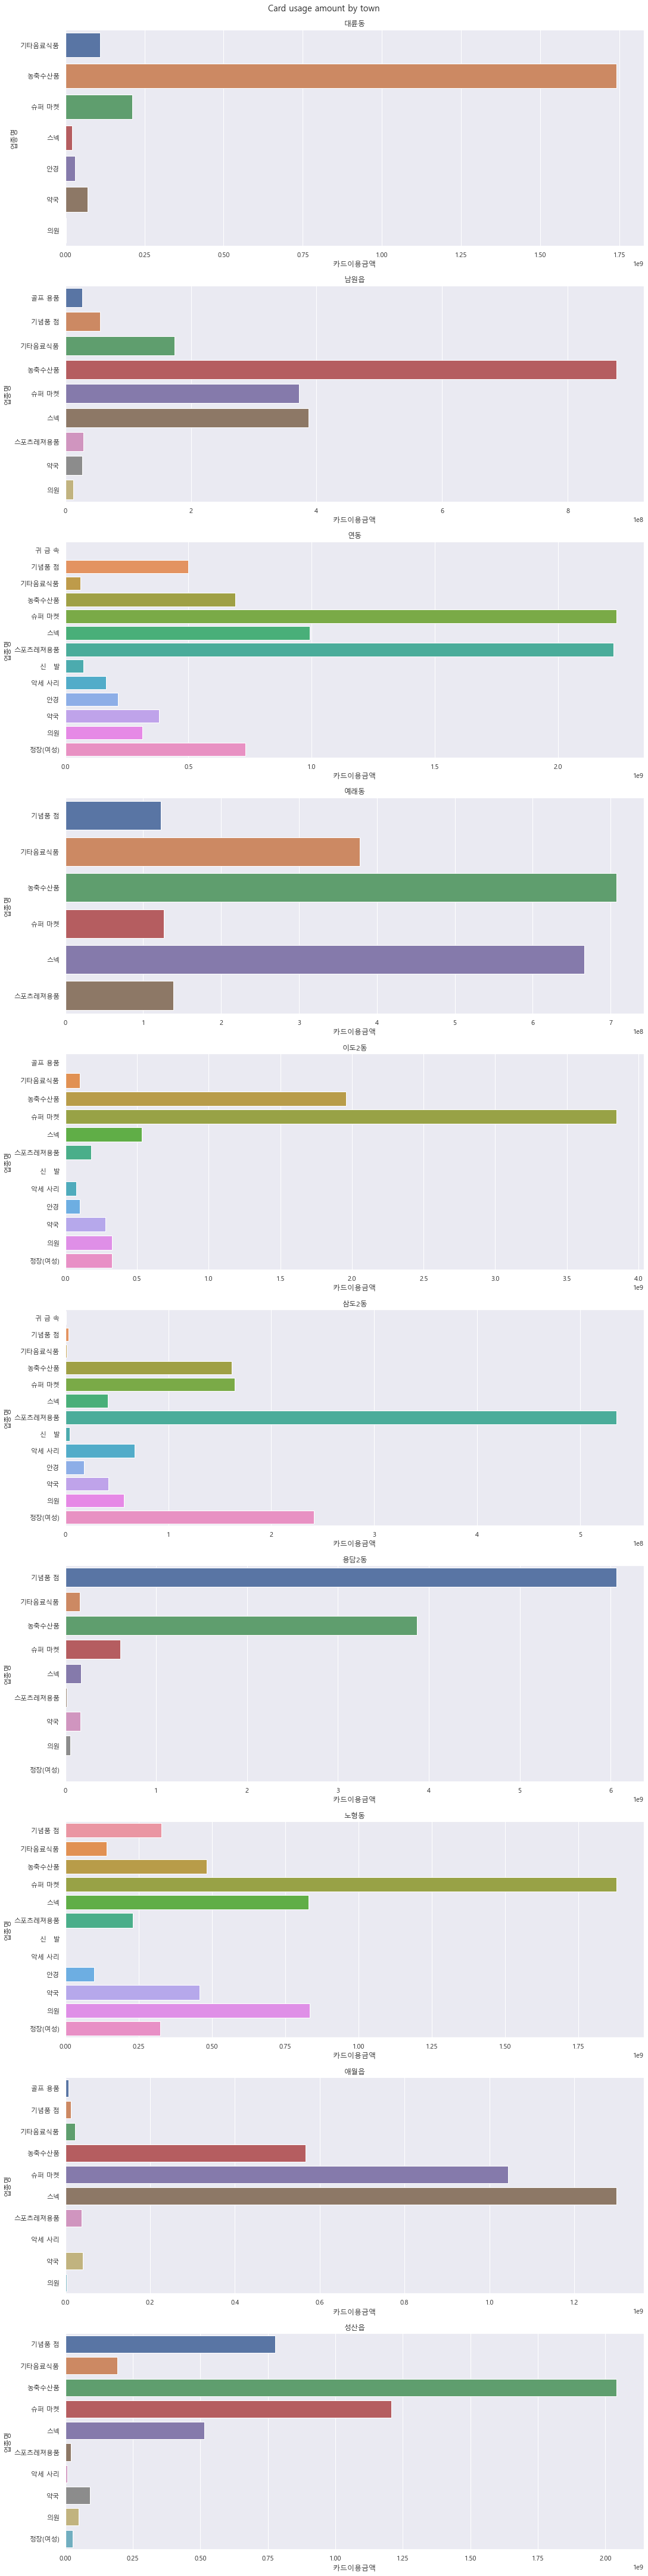

In [422]:
# 지역별로 소비된 업종 분포(카드사용금액 기준)
group_by_town_and_industry = data.groupby(['제주 중분류','업종명']).sum()
group_by_town_and_industry_df = group_by_town_and_industry.reset_index()

fig, axes = plt.subplots(nrows=len(town_in_jejudo),figsize=(15,60),constrained_layout=True)

for idx, town in enumerate(town_in_jejudo):
    sns.barplot(ax=axes[idx],x='카드이용금액',y='업종명',data=card_usage_amount_by_town_df[card_usage_amount_by_town_df['제주 중분류']==town])
    axes[idx].set_title(town)

plt.suptitle('Card usage amount by town')

Text(0.5, 0.98, 'Number of card usage by town')

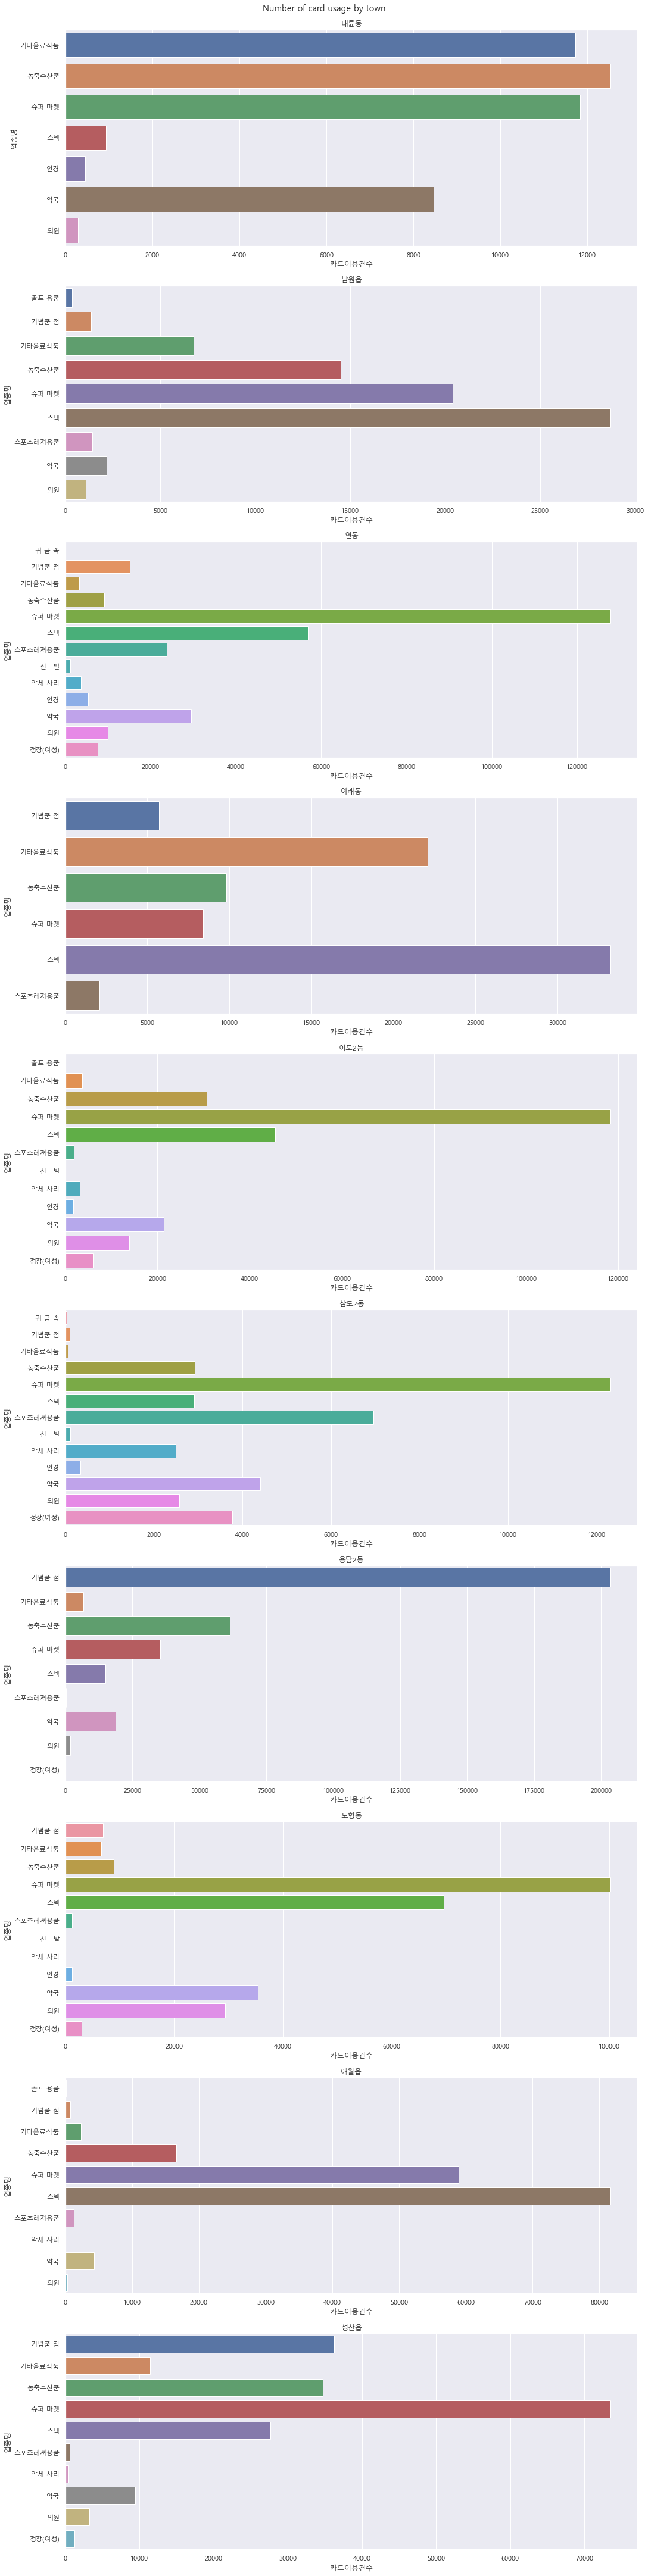

In [424]:
# 지역별로 소비된 업종 분포(카드이용건수 기준)
fig, axes = plt.subplots(nrows=len(town_in_jejudo),figsize=(15,60),constrained_layout=True)

for idx, town in enumerate(town_in_jejudo):
    sns.barplot(ax=axes[idx],x='카드이용건수',y='업종명',data=group_by_town_and_industry_df[group_by_town_and_industry_df['제주 중분류']==town])
    axes[idx].set_title(town)

plt.suptitle('Number of card usage by town')

KeyError: '제주 중분류'

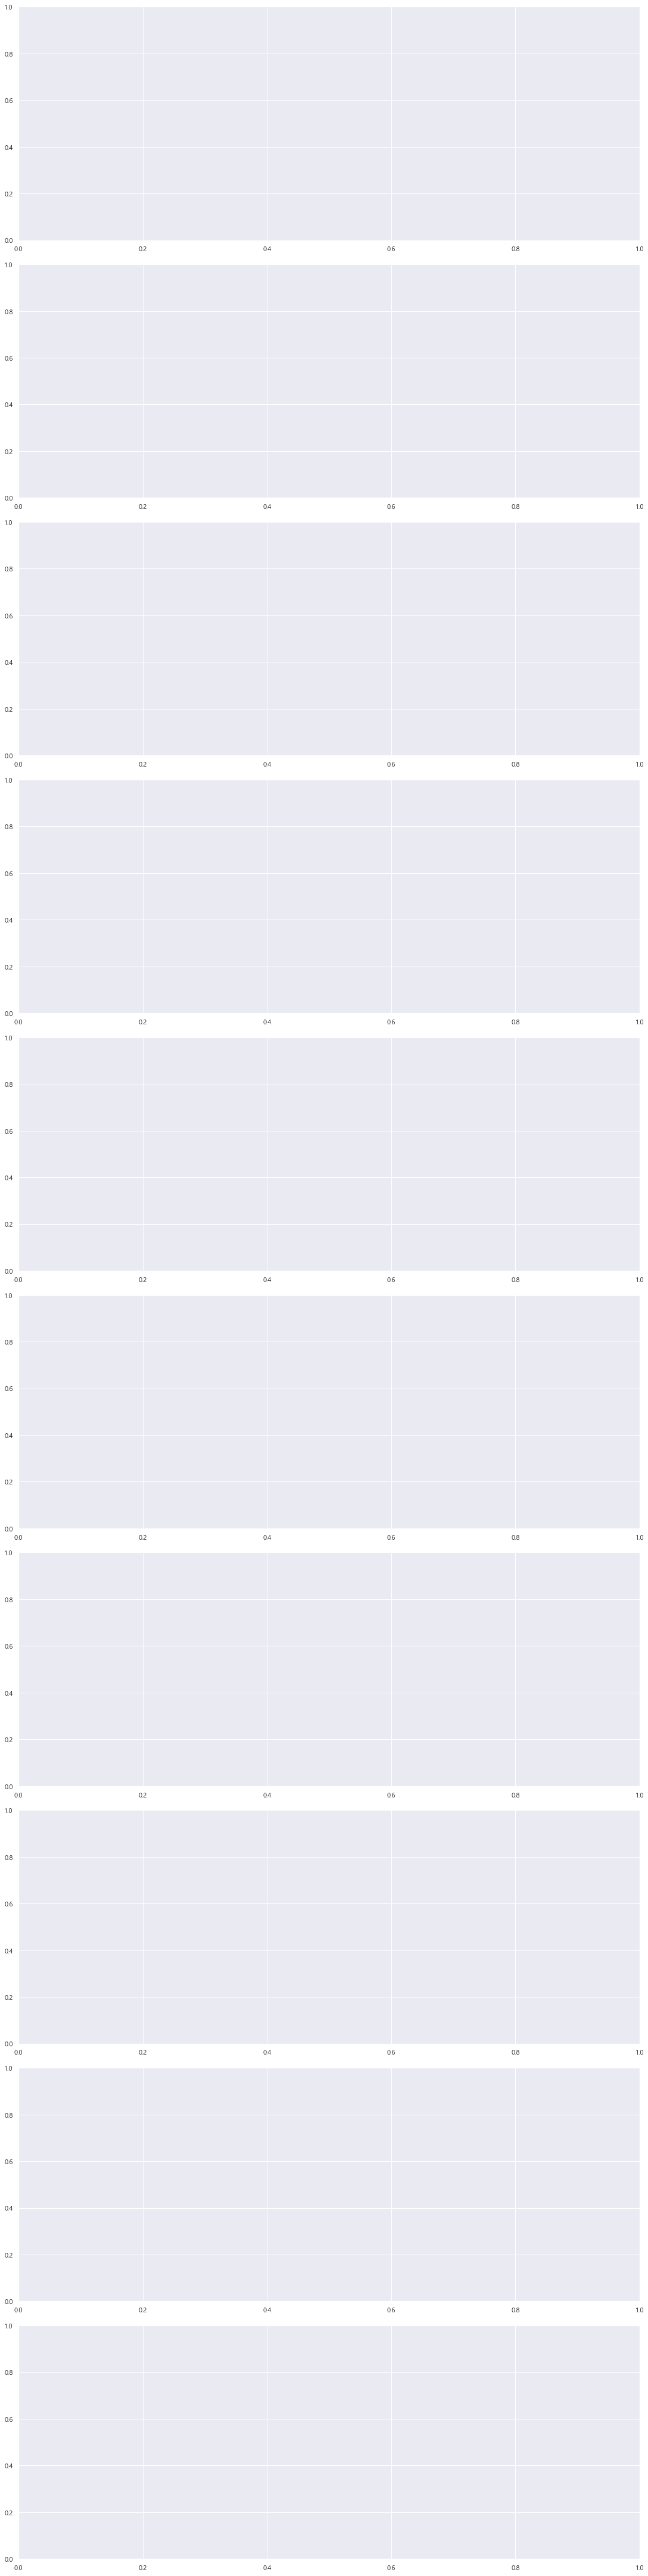

In [433]:
# 지역별로 소비된 업종 분포(사용 건수별)
number_of_card_usage_by_town = data.groupby(['제주 중분류','업종명'])['카드이용건수'].sum()
number_of_card_usage_by_town_df = number_of_card_usage_by_town.to_frame('카드이용건수').reset_index()
fig, axes = plt.subplots(nrows=len(town_in_jejudo),figsize=(15,60),constrained_layout=True)

for idx, town in enumerate(town_in_jejudo):
    sns.barplot(ax=axes[idx],x='카드이용건수',y='업종명',data=number_of_card_usage_by_town[number_of_card_usage_by_town['제주 중분류']==town])
    axes[idx].set_title(town)

plt.suptitle('Number of card usage by town')

Text(0.5, 0.98, 'Age group by town')

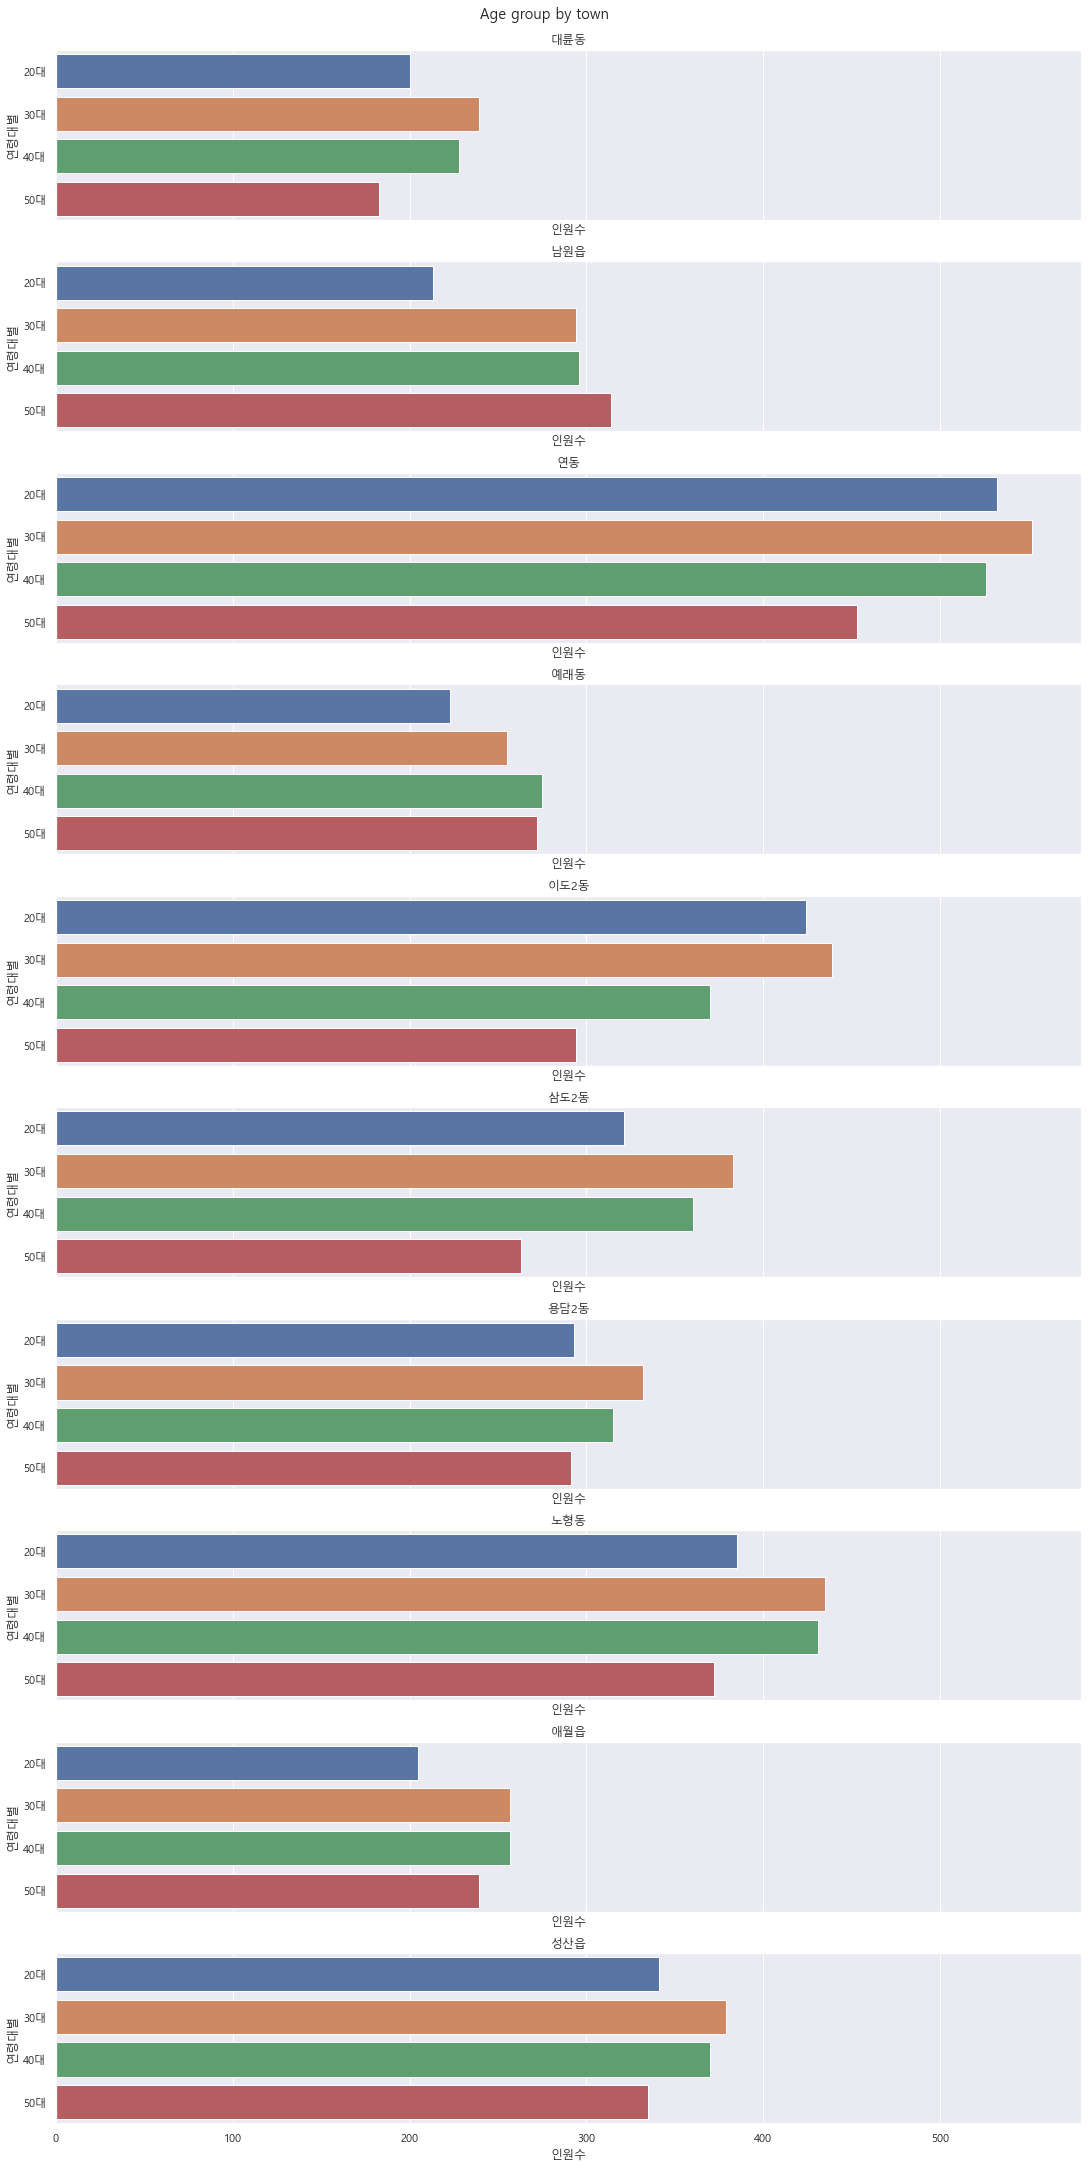

In [398]:
# 지역별로 소비된 연령대
age_grp_by_town = data.groupby(['제주 중분류','연령대별']).size()
age_grp_by_town_df = age_grp_by_town.to_frame('인원수').reset_index()
fig, axes = plt.subplots(nrows=len(town_in_jejudo),figsize=(15,30),sharex=True,constrained_layout=True)

for idx, town in enumerate(town_in_jejudo):
    sns.barplot(ax=axes[idx],x='인원수',y='연령대별',data=age_grp_by_town_df[age_grp_by_town_df['제주 중분류']==town])
    axes[idx].set_title(town)

plt.suptitle('Age group by town')

Text(0.5, 1.0, '지역별 카드 이용 건수')

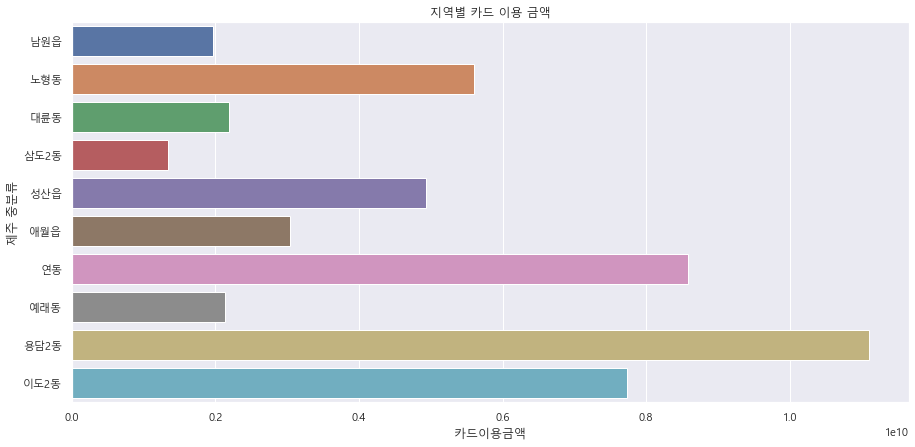

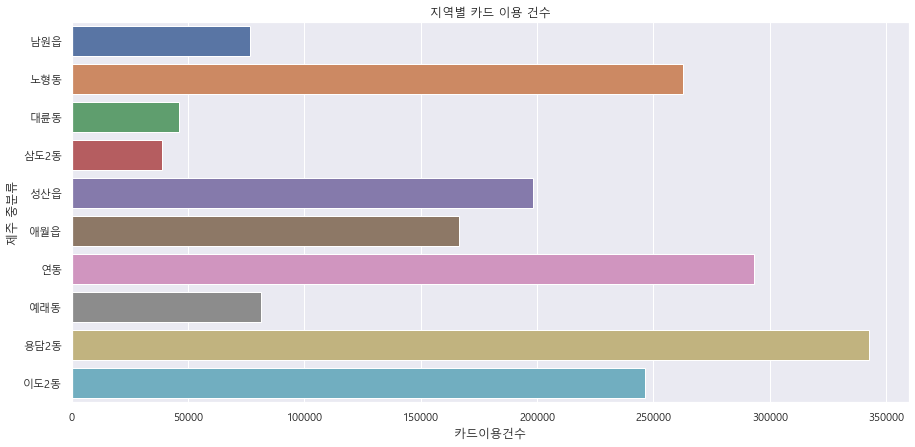

In [416]:
# 지역별 카드 이용 금액
card_usage_amount_town = data.groupby('제주 중분류')['카드이용금액'].sum()
card_usage_amount_town_df = card_usage_amount_town.to_frame('카드이용금액').reset_index()
plt.figure(figsize=(15,7))
ax= sns.barplot(x='카드이용금액',y='제주 중분류',data=card_usage_amount_town_df)
ax.set_title('지역별 카드 이용 금액')

# 지역별 카드 이용 건수
number_of_card_usage_by_town = data.groupby('제주 중분류')['카드이용건수'].sum()
number_of_card_usage_by_town_df = number_of_card_usage_by_town.to_frame('카드이용건수').reset_index()
plt.figure(figsize=(15,7))
ax= sns.barplot(x='카드이용건수',y='제주 중분류',data=number_of_card_usage_by_town_df)
ax.set_title('지역별 카드 이용 건수')